### Is it worth introducing artifical lightinging greenhouses for vegetable growth in Bogota- Colombia ?

I have received several questions of people wondering if it is worth introducing artificial lighting in green hauses in Bogota. For rooftop city gardening or classical greenhaus applications you would like to quantify how much solar photons are getting to your crop, and if its worth to pay for a system that delivers complementary photons to enhance prodiction around the year. 

I break this question into three questions that can be adressed quantitaviely based on irradiation data.
1) what are the average hours of light per day in the region
2) how much energy in forms of usable photons per square meter are shining in the region per day
3) is there an influence if the inmediate enviroments is the city (for rooftop gardening) or agricultural lands (for large scale production) 

I will address these questions using data from the National Solar Radiation Database (NSRDB), which has satellite data from 1998 to 2018. 

The first step is to download the data from the NSRDB website, https://maps.nrel.gov/nsrdb-viewer for the region with the coordinates (4.77, -74.02) to (4.49, -74.18), which spans a rectangular network around Bogota. To compare data of the city the that of the adjacent north region, which is known for its large greenhaus cultures, I also downloaded the data for the region with coordinates (4.81, -74.14) to (4.97, -73.94), which will be refered to "north" of bogota. These regions are roughly 400km2 in extension. If you want to check these regions you can do this easily at http://www.hamstermap.com/quickmap.php. 

Once the download is ready, I load the data into this notebook to adress this question

In [1]:
import os
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
import time
sns.set(style="darkgrid")


In [2]:
data_dir_bogota= r'.\data\data_irradiation_bogota'
data_dir_north_bogota= r'.\data\data_irradiation_north_bogota'

In [3]:
start = time.time()
file_list_bogota=os.listdir(data_dir_bogota)
df_bogota=pd.DataFrame()
for file in file_list_bogota:
    df=pd.read_csv(data_dir_bogota+ '\\' +file, header=2)
    df['region_type']='city'
    df['file']=file
    df_bogota=df_bogota.append(df)
    
file_list_north_bogota=os.listdir(data_dir_north_bogota)
for file in file_list_north_bogota:
    df=pd.read_csv(data_dir_north_bogota+ '\\' +file, header=2)
    df['region_type']='north'
    df['file']=file
    df_bogota=df_bogota.append(df)
end=time.time()
print('Total time', end-start)

Total time 730.7293486595154


This is the raw data, now lets arrange it a bit, look at its head and shape

In [4]:
df_bogota['site']=df_bogota['file'].apply(lambda x:int(x.split('_')[0]))
df_bogota['latitude']=df_bogota['file'].apply(lambda x:float(x.split('_')[1]))
df_bogota['longitude']=df_bogota['file'].apply(lambda x:float(x.split('_')[2]))
df_bogota['region_type']=df_bogota['region_type'].astype(str)
df_bogota.head()

,Year,Month,Day,Hour,Minute,GHI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,region_type,file,site,latitude,longitude
0,2008,1,1,0,30,0,8.0,0.204,0.9,75.39,11.0,790.0,city,1238401_4.77_-74.18_2008.csv,1238401,4.77,-74.18
1,2008,1,1,1,30,0,8.0,0.204,0.9,79.10,11.0,780.0,city,1238401_4.77_-74.18_2008.csv,1238401,4.77,-74.18
2,2008,1,1,2,30,0,8.0,0.204,0.8,78.30,10.0,780.0,city,1238401_4.77_-74.18_2008.csv,1238401,4.77,-74.18
3,2008,1,1,3,30,0,8.0,0.204,0.8,77.74,10.0,790.0,city,1238401_4.77_-74.18_2008.csv,1238401,4.77,-74.18
4,2008,1,1,4,30,0,8.0,0.204,0.8,76.93,10.0,790.0,city,1238401_4.77_-74.18_2008.csv,1238401,4.77,-74.18


In [5]:
print('The number of entries:',df_bogota.shape[0])
print('The number of sites: ', len (set(df_bogota['site'])))
print('The number of Years: ', len (set(df_bogota['Year'])))
print('For 365 days/year, we expect {} entries:'.format(len(set(df_bogota['site']))*len(set(df_bogota['Year']))*365*24))

The number of entries: 7323360
The number of sites:  76
The number of Years:  11
For 365 days/year, we expect 7323360 entries:


Let us now check if we have Na's, and the columns types

In [6]:
set(df_bogota['Year'])

{2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}

In [7]:
df_bogota.isna().sum().sum()

0

In [8]:
df_bogota.dtypes

Year                   int64
Month                  int64
Day                    int64
Hour                   int64
Minute                 int64
GHI                    int64
Dew Point            float64
Surface Albedo       float64
Wind Speed           float64
Relative Humidity    float64
Temperature          float64
Pressure             float64
region_type           object
file                  object
site                   int64
latitude             float64
longitude            float64
dtype: object

The data set is quite forgiving because it does not have any na's, and most of the data are numeric. Now I will perfom some data wrangling to have the information needed. 

The column GHI, gives the horizontal global irradiance (including the direct normal irradiance, and the diffuse horizontal irradiance) in W/m2. Lets aggregate the data of the years 2008-2018, and plot the average irradiance evolution over the day for the different months

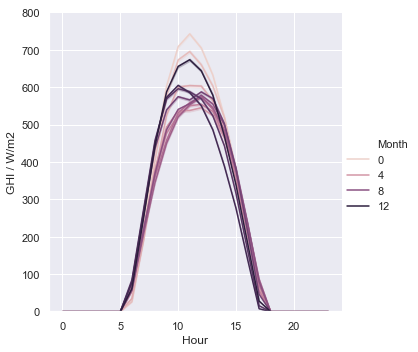

In [9]:
import warnings
warnings.filterwarnings('ignore')
g=sns.relplot(x='Hour', y='GHI', data=df_bogota, hue='Month' ,kind='line')
g.set(ylabel='GHI / W/m2', ylim=(1,800))

As seen from the graph above, and explained by the geographical situation close to the equator, the sunrise and sunset times did not vary significantly above the imte resolution (1 hour). Therefore we can aggregate the data to answer the first question: what are the average daily hours in the region of interest? For this we assume that sunhours start when the irradiation is above 100W/m2, which is a reasonable assumption.

In [10]:
grouped_hour=df_bogota.groupby(['Hour']).agg({'GHI':['mean']})
grouped_hour.columns = ['GHI_mean']
grouped_hour=grouped_hour.reset_index()
daily_hours=grouped_hour['GHI_mean']>100
print('Daily sun hours in the region of Bogota is {} hours'.format(daily_hours.sum()))

Daily sun hours in the region of Bogota is 10 hours


Therefore plants have in mean 14h to produce energy from the sugars produced from photosynthesis, during the so called plant respiration process. Depending on the plant, these amount of time can be sufficent or can be superfluos. 
Now, to obtain the total energy available for photosynthesis, clearly, and based on the graph above, a mean daily amount of light is not enough. We need to intgrate the irradeiance over the day, and we see that we need to adress this as a fnction of the month.

In [11]:
grouped_month=df_bogota.groupby(['Month', 'Hour', 'region_type']).agg({'GHI':['mean']})
grouped_month.columns=['GHI_mean']
grouped_month=grouped_month.reset_index()

int_grouped_month=pd.DataFrame()
for month in set(grouped_month['Month']):
    for region in set(grouped_month['region_type']):
        df=grouped_month[(grouped_month['Month']==month)&(grouped_month['region_type']==region)]
        df['GHI_cumsum']=np.cumsum(df['GHI_mean'])
        int_grouped_month=int_grouped_month.append(df)
int_grouped_month=int_grouped_month[int_grouped_month['Hour']==23]
int_grouped_month=int_grouped_month.drop(['Hour', 'GHI_mean'], axis=1)
int_grouped_month.head(2)

,Month,region_type,GHI_cumsum
47,1,north,5258.190860
46,1,city,5242.117962


This data is Wh/m2, and is distributed over the whole wavelength spectrum. However it is know that only the wavelengths from 400 to 700 nm contribute to photosynthesis, which in terms of irradiance is about 45% of the energy irradiated. This ignores that at lower intensites the spectrum will change (lets recall the colors at sunset and sunrise), but we will neglect this for the moment. On the other hand, plant growers are more used to units of micromols of photons per m2, rather than Wh/m2. We assume a conversion factor of 8.5 mols/m2 per 1000Wh/m2, which once again assumes a fixed solar spectrum (spectrum AM1.5). Making these assumptions we can answer the second question: how much photons are available for plant growth per day?

In [12]:
int_grouped_month['mols_m2']=int_grouped_month['GHI_cumsum']*0.45/1000*8.5

In [13]:
umols_region=int_grouped_month.groupby(['region_type']).agg({'mols_m2':['mean']})
umols_region.columns=['mols_m2_mean']
umols_region=umols_region.reset_index()
umols_region

,region_type,mols_m2_mean
0,city,17.967812
1,north,17.592073


The average number of photons available per day is slightly larger in the city. This is most probably due to the larger diffused irradiation present in the city.

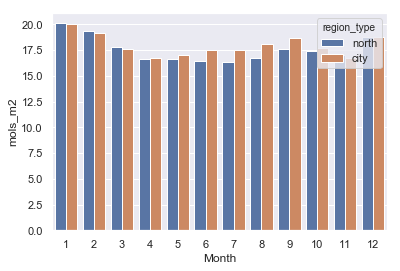

In [14]:
g=sns.barplot(x='Month', y='mols_m2', hue='region_type',data=int_grouped_month)


A significant decrease in photon number is observed from January to June, and the maximum difference between the city and the rural north, is observed in september. REcall that this assumes a perfectly transparent greenhaus, which is far from reality. For more realistic estimation a factor of 0.7 to 0.9 should be multiplied to these values depending on the greenhaus material. 

In the use case of canopy growth, it has been reported that an optimum in organic mass will be obtained at about 30 Moles per day with 12h cycles. The graph below shows how much Moles are missing to achieve this

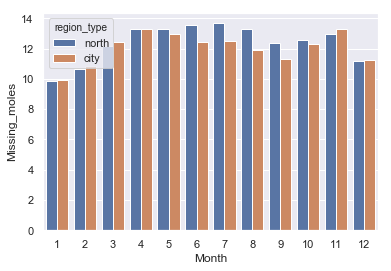

In [15]:
int_grouped_month['Missing_moles']=30-int_grouped_month['mols_m2']
g=sns.barplot(x='Month', y='Missing_moles', hue='region_type',data=int_grouped_month)

In [18]:
int_grouped_month['Missing_moles_per_month']=int_grouped_month['Missing_moles']*30
sum_missing_mols=int_grouped_month.groupby(['region_type']).agg({'Missing_moles_per_month':['sum']})
sum_missing_mols.columns=['sum_missing_moles_year']
sum_missing_mols=sum_missing_mols.reset_index()
sum_missing_mols['sum_missing_kWh_year']=sum_missing_mols['sum_missing_moles_year']/0.45/8.5
sum_missing_mols['Cost_per_m2_per_year_USD']=sum_missing_mols['sum_missing_kWh_year']*0.16*1.1
sum_missing_mols

,region_type,sum_missing_moles_year,sum_missing_kWh_year,Cost_per_m2_per_year_USD
0,city,4331.587753,1132.441243,199.309659
1,north,4466.853668,1167.804881,205.533659


The estimated cost per year assumes a tarif of 0.16$/kWh and a lighting effciency of 90\%. 

A final point that should be taken into account is the difference in the average temperatures, dew points ane relative humidity.

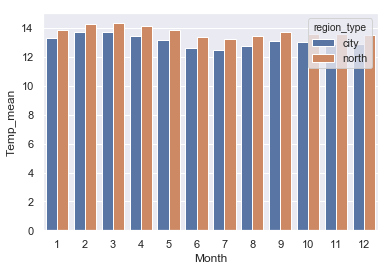

In [24]:
grouped_month_Temp=df_bogota.groupby(['region_type']).agg({'Temperature':['mean'], 'Dew Point':['mean'],'Relative Humidity':['mean'] })
grouped_month_Temp.columns=['Temp_mean', 'Dew_point_mean', 'Rel_Hum_mean']
grouped_month_Temp=grouped_month_Temp.reset_index()

sns.barplot(x='Month', y='Temp_mean', hue='region_type',data=grouped_month_Temp)

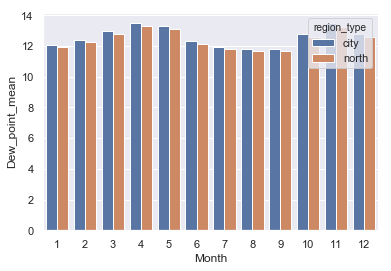

In [25]:
sns.barplot(x='Month', y='Dew_point_mean', hue='region_type',data=grouped_month_Temp)

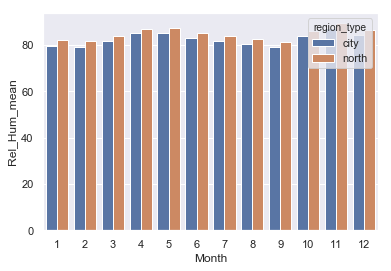

In [26]:
sns.barplot(x='Month', y='Rel_Hum_mean', hue='region_type',data=grouped_month_Temp)

Finally lets look at the hours of the day where fog, or condensation is possible (where the temperature is lower than the dew point) 

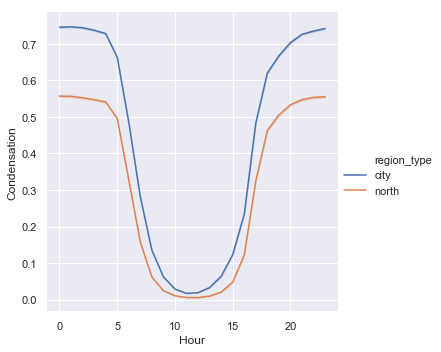

In [44]:
df_bogota['Condensation']=(df_bogota['Temperature']-df_bogota['Dew Point'])<0
g=sns.relplot(x='Hour', y='Condensation', data=df_bogota, hue='region_type' ,kind='line')

This answers the third question: what is the influence of the inmediate environment? The north of the city has a slighter higher temperaure (some degrees), dew point and relative humidity remaining almost constant. This leads to a larger amount of hours where fog is present, which will surely affect any electronic equipment that es exposed to the environment.

With these Infos the grower should now be capable of calculating if its worth for him, depending on the value of his crops, installing artificial lighting.